# TP noté 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leoolivier/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Article 1 : association statin therapy reduced intracranial aneurysm recurrence endovascular coiling post hoc propensity scorematched analysis randomized clinical trial


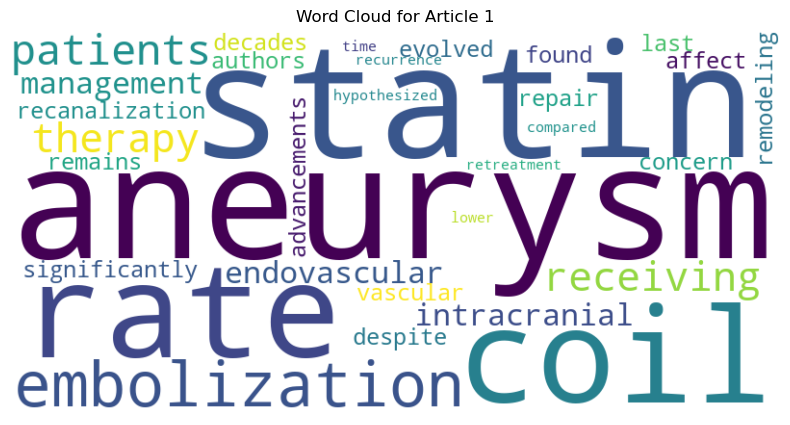

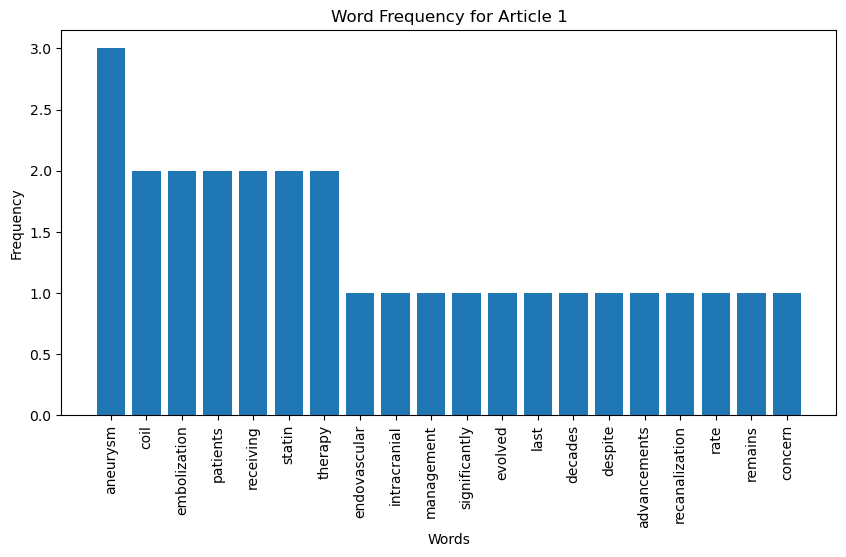


Article 2 : natural history dolichoectatic vertebrobasilar aneurysms multinational study


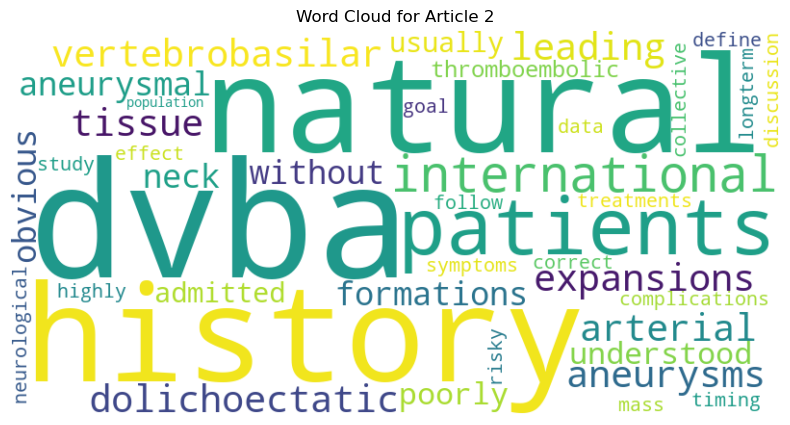

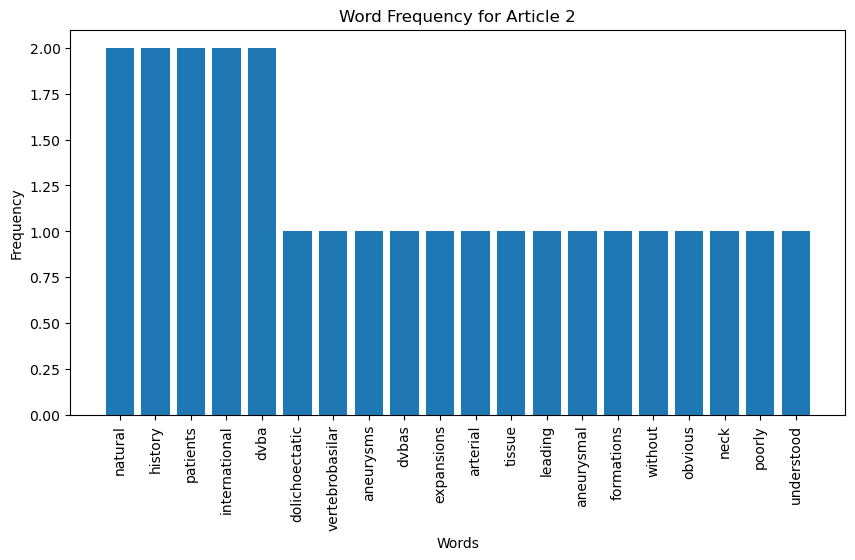


Article 3 : effect thrombolysis alteplase patients vessel occlusion wake trial


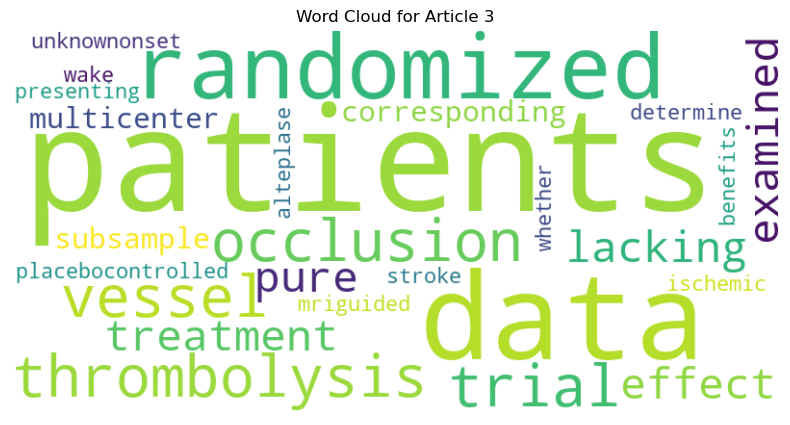

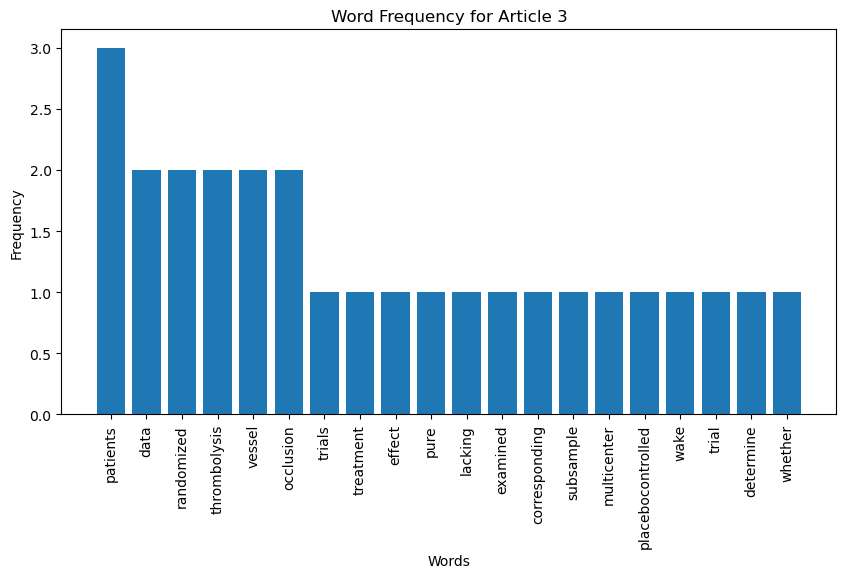


Article 4 : effectiveness optic nerve sheath diameter predicting large vessel occlusion ischemic stroke patients


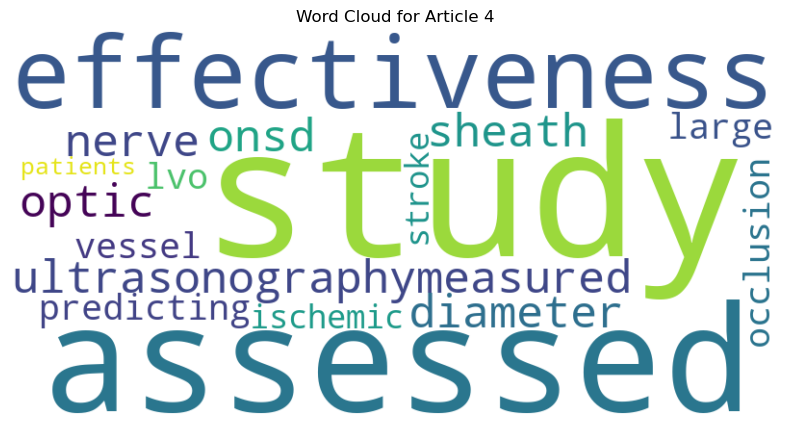

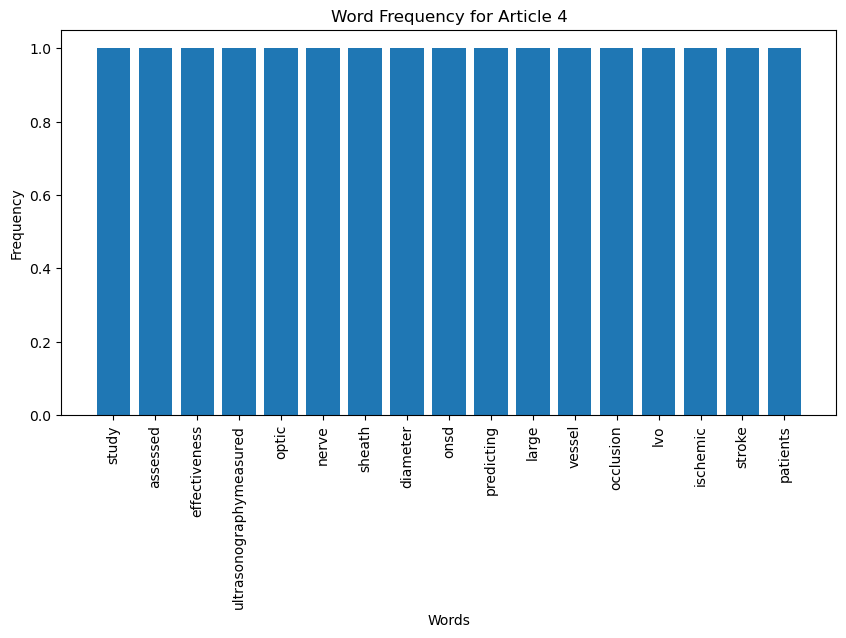


Article 5 : cerebral hemodynamic responses diseasemodifying curative sickle cell disease therapies


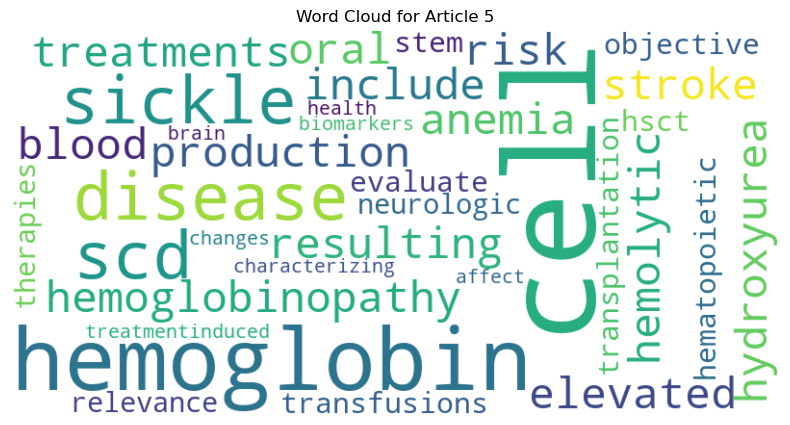

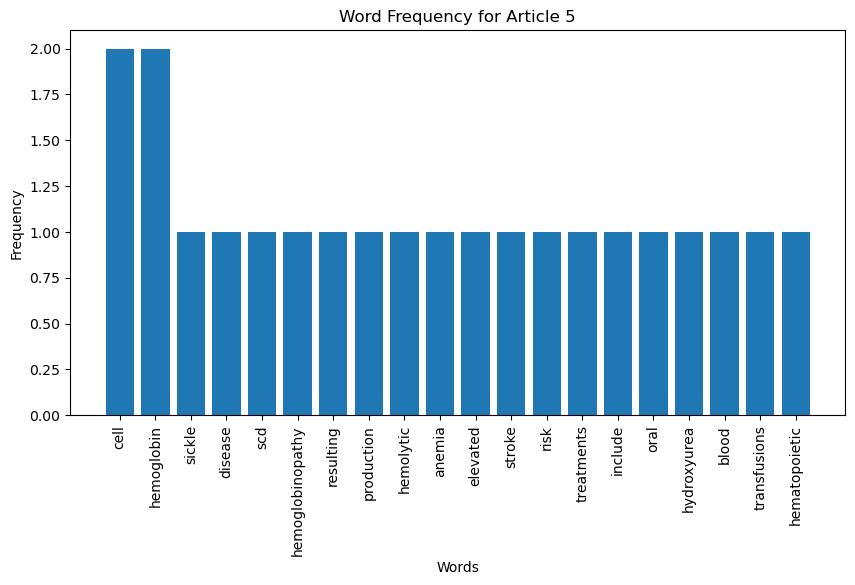


Article 6 : power strokes molecular motors predictive irrelevant somewhere


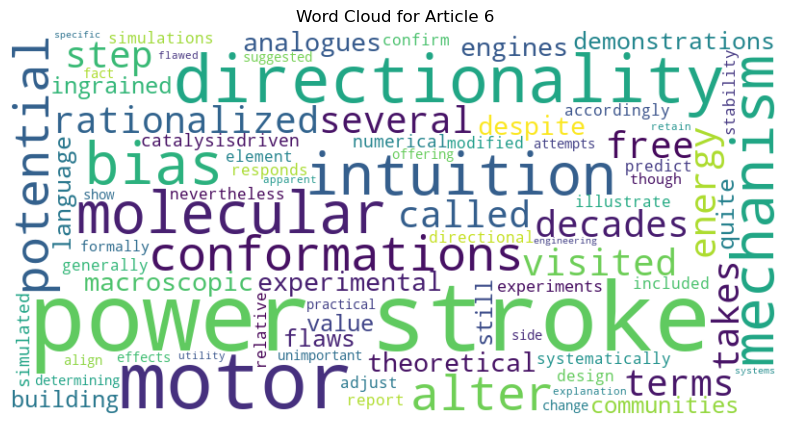

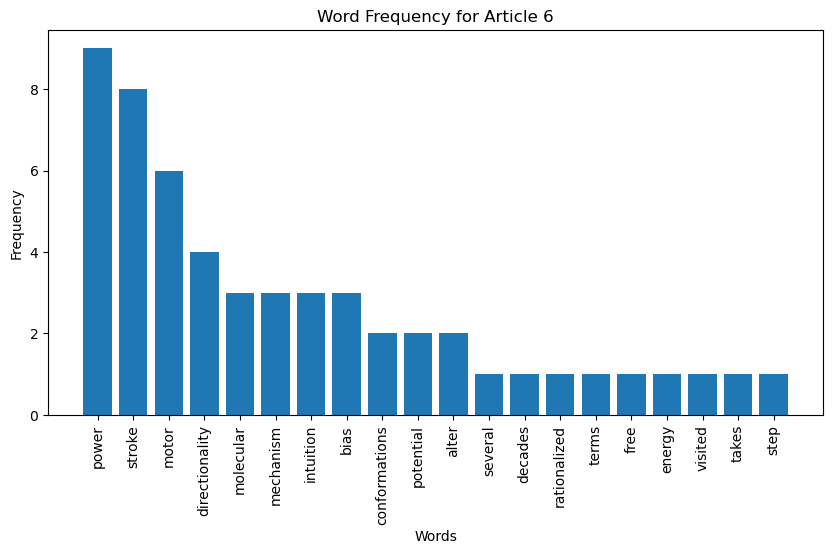


Article 7 : adverse effect mood swings risk cardiovascular diseases evidence mendelian randomization analysis


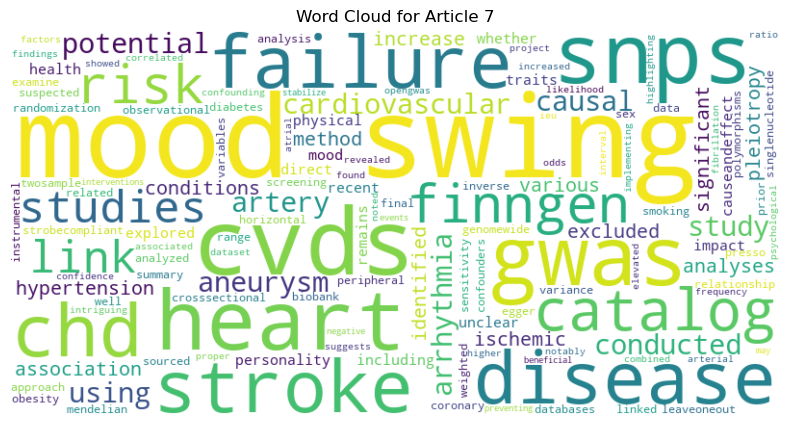

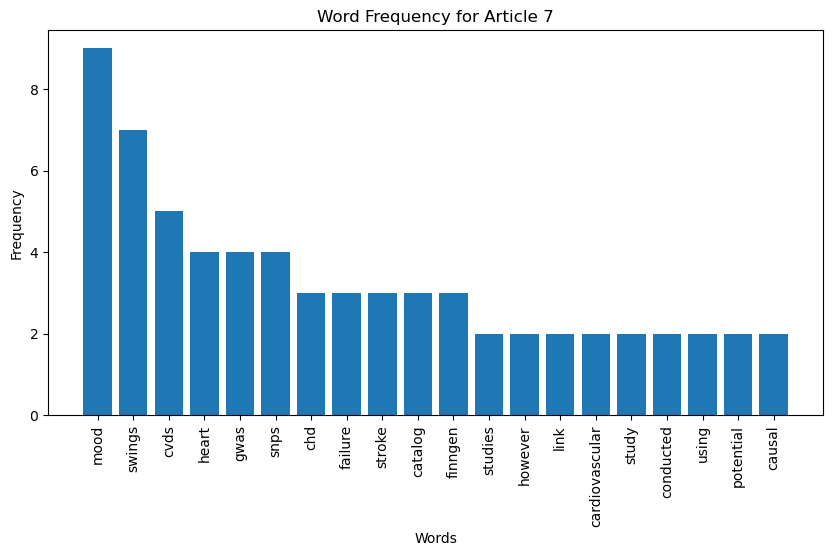


Article 8 : bilateral thalamic infarction posterior cerebral artery variant arcade artery case report


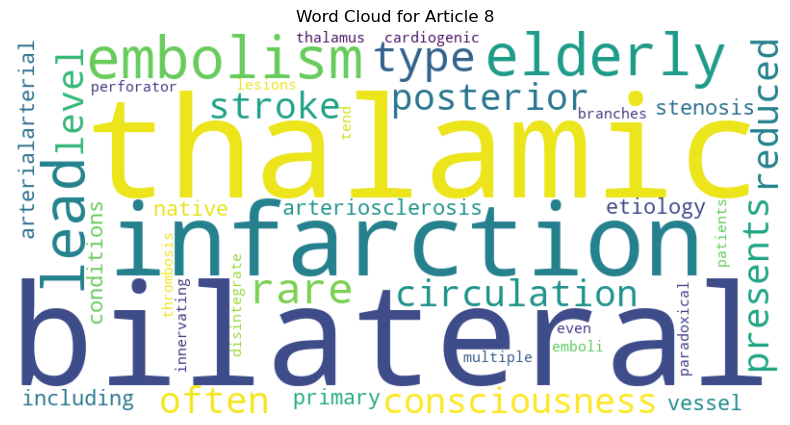

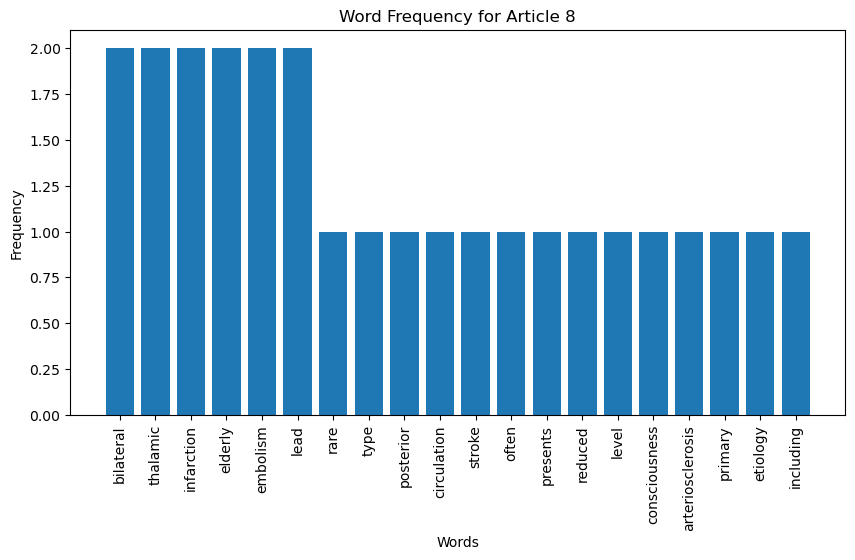


Article 9 : nonstenotic carotid artery plaques computed tomography angiography embolic stroke undetermined source


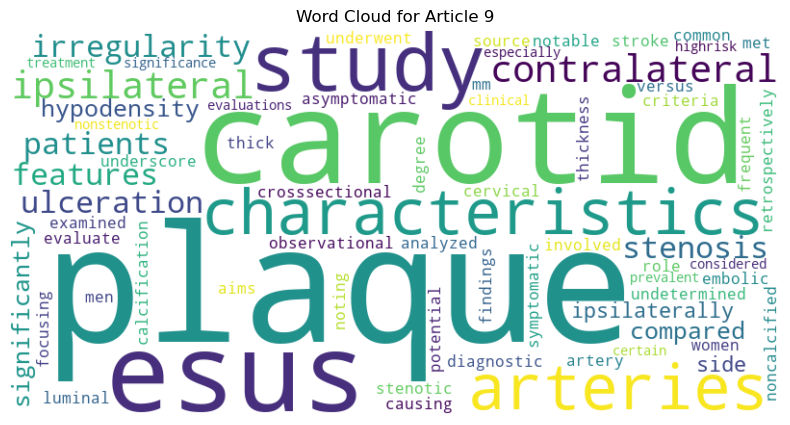

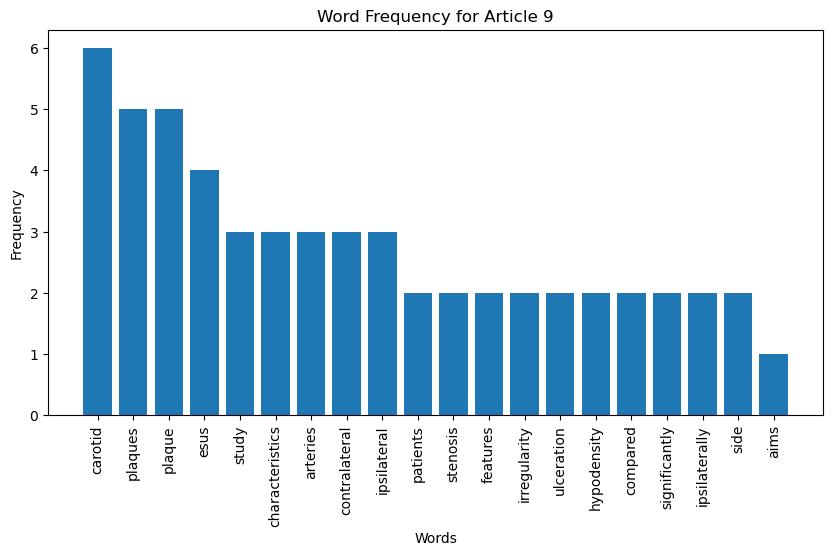


Article 10 : pathological roles mitochondrial dysfunction endothelial cells cerebral reflow phenomenon review


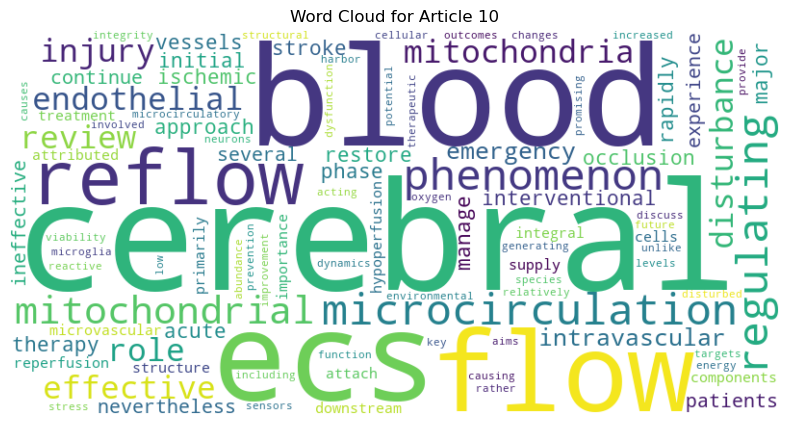

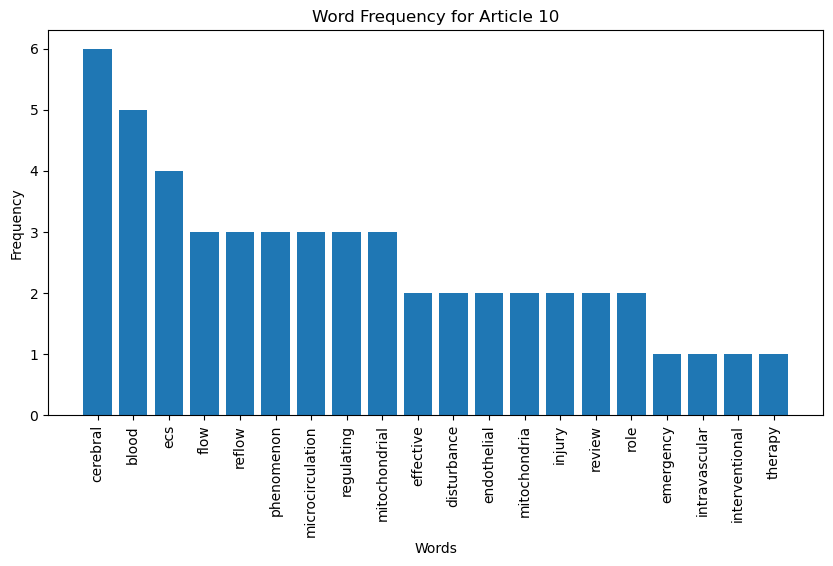

In [5]:
import requests
import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords

#  stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# articles de PubMed
def get_pubmed_articles(keyword, max_results):
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    params = {
        "db": "pubmed",
        "term": keyword,
        "retmax": max_results,
        "retmode": "json",
    }
    response = requests.get(base_url, params=params)
    data = response.json()
    return data.get("esearchresult", {}).get("idlist", [])

# Articles & resumé 
def get_article_details(article_ids):
    details_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    details_params = {
        "db": "pubmed",
        "id": ",".join(article_ids),
        "retmode": "xml",
        "rettype": "abstract",
    }
    response = requests.get(details_url, params=details_params)
    articles = []
    if response.status_code == 200:
        from xml.etree import ElementTree as ET
        root = ET.fromstring(response.content)
        for article in root.findall(".//PubmedArticle"):
            title = article.findtext(".//ArticleTitle", default="Titre non disponible")
            abstract = article.findtext(".//AbstractText", default="Résumé non disponible")
            journal = article.findtext(".//Journal/Title", default="Journal non disponible")
            pubdate = article.findtext(".//PubDate/Year", default="Date non disponible")
            article_id = article.findtext(".//ArticleId[@IdType='pubmed']", default="ID non disponible")
            articles.append({
                "Titre": title,
                "Résumé": abstract,
                "Journal": journal,
                "Date de publication": pubdate,
                "URL PubMed": f"https://pubmed.ncbi.nlm.nih.gov/{article_id}"
            })
    return articles

# Pipeline de prétraitement pour les résumés et les titres
def preprocess_text(text):
    text = text.lower()  # Convertir en minuscules
    text = re.sub(r'\b\w{1,2}\b', '', text)  # Supprimer les mots de 1 ou 2 lettres
    text = re.sub(r'\d+', '', text)  # Supprimer les chiffres
    text = re.sub(r'[^\w\s]', '', text)  # Supprimer la ponctuation
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Supprimer les stopwords
    return ' '.join(words)

# Nuage de mots 
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# fréquence des mots
def plot_word_frequency(text, title):
    words = text.split()
    word_freq = Counter(words)
    common_words = word_freq.most_common(20)
    
    words, counts = zip(*common_words)
    
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.xticks(rotation=90)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

# Récupérer les articles et leurs détails
keyword = "stroke"
max_results = 10
article_ids = get_pubmed_articles(keyword, max_results)
articles = get_article_details(article_ids)

# Appliquer le prétraitement 
for article in articles:
    article['Titre'] = preprocess_text(article['Titre'])
    article['Résumé'] = preprocess_text(article['Résumé'])

# Sauvegarder fichier CSV
df = pd.DataFrame(articles)
df.to_csv("articles_pubmed_stroke.csv", index=False, encoding="utf-8")

# un nuage de mots et une visualisation de la fréquence des mots pour chaque article
for idx, article in enumerate(articles):
    print(f"\nArticle {idx + 1} : {article['Titre']}")
    
    # Nuage de mots pour le résumé de l'article
    create_wordcloud(article['Résumé'], f"Word Cloud for Article {idx + 1}")
    
    # Fréquence des mots pour le résumé de l'article
    plot_word_frequency(article['Résumé'], f"Word Frequency for Article {idx + 1}")